# Algorithmes évolutionnaires pour le maillage quadrangulaire

### Objectif: Expérimenter avec les paramètres d'un algorithme évolutionnaire et étudier leur influence

Il nous faut être en mesure de:
- générer les points formant le conour d'une forme et des points intérieurs
- former des maillages à partir de ces points
- calculer la qualité des maillages
- classer les maillages selon leur qualité
- croiser les maillages de différentes manières
- effectuer une mutation sur un maillage

## Exemple sur un polygone convexe

Le code suivant génère des points du contours et intérieurs, et crée un maillage triangulaire.

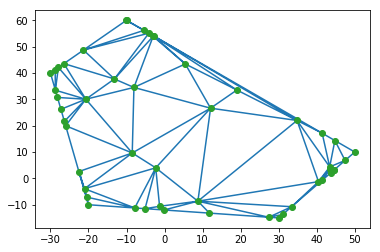

In [0]:
import matplotlib.pyplot as plt
import numpy as np
import random
from scipy.spatial import Delaunay #debug
#points est initialise avec les sommets de la figure
points = np.array([[-20.0, -10.0], [-30.0, 40.0],[-10.0,60.0],[50.0, 10.0],[30.0, -15.0]])

#nombre de point genere sur chaque segment 
nbPointTour = 5 
#nombre de point genere dans la figure
nbPointCentre = 20

#Fonction creant un point aleatoirement sur un segment
def RandomPoint(A,B,points):
	#Verifie si on ne divise pas par zero pour le coefficiant directeur du segment
	coefficient = 0.0 + (points[B][0]-points[A][0])
	if coefficient == 0:
		coefficient = 1
		C=points[A][0]
		D=random.uniform(points[A][1],points[B][1])
	else :
		coefficient = (points[B][1]-points[A][1])/coefficient
		b = points[A][1] - coefficient*points[A][0]
		C=random.uniform(points[A][0],points[B][0])
		D = coefficient*C+b
	return [C,D]

#Fonction de generation des points 
def GenerationContour(nbPointTour,points):
	#Contour
	j=0
	nbPoint = len(points)
	while j < nbPoint:
		if ( j == (nbPoint-1)):
			i = 0
			while i < nbPointTour:
				points = np.concatenate((points,[RandomPoint(0,j,points)]), axis=0)
				i = i + 1
		else:
			i = 0
			while i < nbPointTour:
				points = np.concatenate((points,[RandomPoint(j,j+1,points)]), axis=0)
				i = i + 1
		j=j+1
	CloseFile(points)

#Fonction de generation des points 
def GenerationCentre(nbPointCentre):
	#centre
	points = OpenFile()
	k=0
	while k < nbPointCentre:
		A= random.randint(0,len(points)-1)
		B= random.randint(0,len(points)-1)
		points = np.concatenate((points,[RandomPoint(A,B,points)]), axis=0)
		k=k+1
	CloseFile(points)

def Visuel():
	points = OpenFile()
	#Code pour le visuel
	#from scipy.spatial import Delaunay
	tri = Delaunay(points)
	plt.triplot(points[:,0], points[:,1], tri.simplices.copy())
	plt.plot(points[:,0], points[:,1], 'o')
	plt.show()

def OpenFile():
	points = np.array([[0.0, 0.0]])
	fichier = open("dataPoints.txt", "r")
	for ligne in fichier:
		temp0 = ""
		temp1 = ""
		indice = 0
		for i in ligne:
			if ((i == "-" or i == "." or i.isdigit() == True ) and indice == 0):
				temp0 = temp0+i
			elif i == ",":
				indice = 1
			elif ((i == "-" or i == "." or i.isdigit() == True) and indice == 1):
				temp1 = temp1+i
		points = np.concatenate((points,[[float(temp0),float(temp1)]]), axis=0)
	points = np.delete(points,0,0)
	return points

def CloseFile(points):
	w=0
	fichier = open("dataPoints.txt", "w")
	while w<len(points):
		temp0 = str(points[w][0])
		temp1 = str(points[w][1])
		write = "["+temp0+","+temp1+"]\n"
		fichier.write(write)
		w=w+1
	fichier.close()

#Le Main de mon code
GenerationContour(nbPointTour,points)
GenerationCentre(nbPointCentre)
Visuel()

## Exemple sur un cercle discrétisé

Le code suivant génère un polygone régulier pour approximer un cercle unité, des points aléatoirement répartis sur le disque, et un maillage triangulaire.

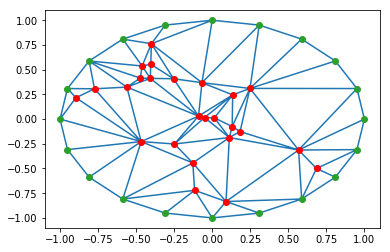

In [0]:
from math import pi, cos, sin, acos

###############################################################################
# METHODES
###############################################################################

# Genere les points formant le contour du cercle
def genererContourCercle(resolution):
  """
  Entree: resolution (nbre de pts de la discretisation du cercle)
  Sortie: numpy.array contenant l'ensemble points de la
  discretisation du cercle

  On genere les points du contour sur un quadrant de facon reguliere, 
  puis on place les symetriques en manipulant les coordonnees:
            _____
          /   |   \ 
        /     |     \ 
      /       |       \ 
    /         |         \ 
   | (-y,x)   |   (x,y)  |
   |----------+----------|
   | (-x,-y)  | (y,-x)   |
    \         |         /
      \       |       / 
        \     |     / 
          \ __|__ /  
  C'est juste pour economiser du temps de calcul sur les cos() et sin(),
  c'est peut-etre pas utile
  """
  
  # On initialise le tableau qui contiendra les points
  ptsContourQuadrant = np.zeros(shape=(resolution*4, 2))

  # On va faire varier l'angle entre 0 et pi/4 (45 deg)
  increment = (pi/2) / resolution
  angle = -increment
  for i in range (resolution):
    angle += increment
    x = cos(angle)
    y = sin(angle)
    ptsContourQuadrant[i] = [x, y]                #top-right
    ptsContourQuadrant[resolution+i] = [-y, x]    #top-left
    ptsContourQuadrant[2*resolution+i] = [-x, -y] #bottom-left
    ptsContourQuadrant[3*resolution+i] = [y, -x]  #bottom-right

  return ptsContourQuadrant

# Sous-fonction de genererInterieurCercle, pour un seul point
def genererPointInterieur(angleMin, angleMax):
  """
  Entree: intervalle d'angle pour des coordonnees polaires
  Sortie: coordonnees d'un point quelconque sur une portion du disque unite
  """
  angle = random.uniform(angleMin, angleMax)
  distance = random.random()
  return [distance * cos(angle), distance * sin(angle)]

# Genere des points aleatoirement dans un disque
def genererInterieurCercle(nbPointsInterieurs):
  # On initialise le tableau qui contiendra les points
  ptsInterieurs = np.zeros(shape=(nbPointsInterieurs, 2))

  for i in range(nbPointsInterieurs):
    ptsInterieurs[i] = genererPointInterieur(0, 2*pi)

  return ptsInterieurs

###############################################################################
# EXECUTION
###############################################################################

# Nombre de points du contour du cercle par quadrant
resolutionQuadrant = 5
contourCercle = genererContourCercle(resolutionQuadrant)

# Nombre de points interieurs au cercle
nbPtsDansCercle = 25
interieurCercle = genererInterieurCercle(nbPtsDansCercle)

# Tous les points regroupes dans un tableau
pointsCercle = np.concatenate((contourCercle, interieurCercle), axis=0)

# Creation du maillage
maillageTriCercle = Delaunay(pointsCercle)

###############################################################################
# VISUEL
###############################################################################
plt.triplot(pointsCercle[:,0], pointsCercle[:,1], maillageTriCercle.simplices.copy())
plt.plot(contourCercle[:,0], contourCercle[:,1], 'o')
plt.plot(interieurCercle[:,0], interieurCercle[:,1], 'ro')
plt.show()



## Qualité du maillage triangulaire

Le code suivant permet de donner un critère sur la qualité d'un triangle en considérant l'angle `θ` tel que `θ - 90°` est maximal. La qualité du maillage est la moyenne arithmétique de celle de tous les triangles.

In [0]:
###############################################################################
# QUALITE DES TRIANGLES
###############################################################################


# Sous-fonction pour qualiteTriangle
def calculerAngle(a, b, c):
  """
  Entree: 3 points A[xa, ya], B[xb, yb], C[xc, yc]
  Sortie: angle (AB, AC) en radians

  - On utilise les coordonnees de facon vectorielle: 
  AB = B - A = [xb-xa, yb-ya] etc.
  - On utilise la formule du produit scalaire avec cosinus:
  AB.AC = ||AB||.||AC||.cos(AB,AC) => (AB,AC) = arccos(AB.AC/||AB||.||AC||)
  """
  ab = b - a
  ac = c - a
  prodScal = np.dot(ab,ac)
  prodNorm = np.linalg.norm(ab) * np.linalg.norm(ac)
  return acos(prodScal/prodNorm)


# Qualité d'un seul triangle
def qualiteTriangle(a, b, c):
  """
  Entree: 3 angles a, b, et c en radians
  Sortie: float dans [0,1] en fonction du max(angle - angle_droit)
  """
  ecartAngle1 = abs(calculerAngle(a,b,c) - pi/2)
  ecartAngle2 = abs(calculerAngle(b,c,a) - pi/2)
  ecartAngle3 = abs(calculerAngle(c,a,b) - pi/2)
  ecartMax = max(ecartAngle1, ecartAngle2, ecartAngle3)

  return ecartMax / (pi/2)

# Qualité d'un ensemble de triangles 
def qualiteMaillageTri(triangles, points):
  """
  Entree: 
    - triangles de la forme Delaunay(points).simplices
    - np.array des points du maillage
  Sortie: float dans [0,1]

  Calcule la qualite de tous les triangles et en fait la moyenne arithmetique
  """
  sommeQualite = 0.0

  for triangle in triangles:
    sommeQualite += qualiteTriangle(points[triangle[0]], points[triangle[1]], points[triangle[2]])

  return sommeQualite / len(triangles)

###############################################################################
# TESTS SUR LES EXEMPLES
###############################################################################

#print "Qualite du maillage pour le polygone : "
#print qualiteMaillageTri(tri.simplices, points)

print "Qualite du maillage pour le cercle : "
print qualiteMaillageTri(maillageTriCercle.simplices, pointsCercle)

Qualite du maillage pour le cercle : 
0.675401938813
